<a href="https://colab.research.google.com/github/C242-PS253-Capstone-Team/ML_Face_Shape_Recognition/blob/rifal/ML_Model_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Library

In [ ]:
pip install --upgrade tensorflow keras

In [ ]:
pip install mtcnn

In [ ]:
pip install lz4

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import re
import shutil
import cv2
import tensorflow as tf
import tensorflow_datasets as tfds
import keras
import mtcnn

from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom, RandomContrast, RandomTranslation, RandomBrightness
from keras.utils import plot_model
from matplotlib import pyplot as plt
from mtcnn import MTCNN
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras.applications.mobilenet import preprocess_input

# EDA

#### Load Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_dr = '/content/drive/MyDrive/Dataset_Capstone/Kaggle/combined_data/combined_train'
# train_data_2 = '/content/drive/MyDrive/Dataset_Capstone/Kaggle/men_face_dataset'
# dataset_3 = '/content/drive/MyDrive/Dataset Capstone/'
# ....
# dataset_1 = '/content/drive/MyDrive/Dataset Capstone/'

In [ ]:
val_dr = '/content/drive/MyDrive/Dataset_Capstone/Kaggle/combined_data/combined_test'

In [ ]:
print("Isi folder training:")
print(os.listdir(train_dr))

print("\nIsi folder testing:")
print(os.listdir(val_dr))

Isi folder training:
['Oblong', 'Heart', 'Oval', 'Round', 'Square']

Isi folder testing:
['Square', 'Heart', 'Oval', 'Round', 'Oblong']


In [ ]:
print("Training directory contents:", os.listdir(train_dr))
print("Validation directory contents:", os.listdir(val_dr))

Training directory contents: ['Oblong', 'Heart', 'Oval', 'Round', 'Square']
Validation directory contents: ['Square', 'Heart', 'Oval', 'Round', 'Oblong']


In [ ]:
# Inisialisasi detektor MTCNN
detector = MTCNN()

def extract_face(img, target_size=(224,224)):
    '''this function extracts the face from different images by
    1) finds the facial bounding box
    2) slightly expands top & bottom boundaries to include the whole face
    3) crop into a square shape
    4) resize to target image size for modelling
    5) if the facial bounding box in step 1 is not found, image will be cropped & resized to 224x224 square'''

    # 1. deteksi wajah pada gambar
    results = detector.detect_faces(img)
    if results == []:  # jika wajah tidak terdeteksi, crop & resize dengan mempertahankan rasio aspek
        new_face = crop_and_resize(img, target_w=224, target_h=224)
    else:
        x1, y1, width, height = results[0]['box']
        x2, y2 = x1 + width, y1 + height
        face = img[y1:y2, x1:x2]  # wajah dari bounding box sebelum ekspansi bbox

        # 2. memperbesar bagian atas dan bawah bounding box sebanyak 10 pixel untuk memastikan seluruh wajah terekstrak
        adj_h = 10
        new_y1 = max(0, y1 - adj_h)
        new_y2 = min(img.shape[0], y1 + height + adj_h)
        new_height = new_y2 - new_y1

        # 3. crop gambar menjadi bentuk persegi
        adj_w = int((new_height - width) / 2)
        new_x1 = max(0, x1 - adj_w)
        new_x2 = min(img.shape[1], x2 + adj_w)
        new_face = img[new_y1:new_y2, new_x1:new_x2]  # crop wajah ke bentuk persegi

    # 4. resize gambar ke ukuran target
    sqr_img = cv2.resize(new_face, target_size)
    return sqr_img

# # Fungsi untuk memuat dan mengekstrak wajah dari file gambar
# def extract_face_from_image(image_path):
#     img = cv2.imread(image_path)  # Membaca gambar
#     img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Mengubah gambar menjadi RGB
#     face = extract_face(img_rgb)  # Memanggil fungsi extract_face untuk mengekstrak wajah
#     return face

# # Uji dengan gambar tertentu
# image_path = '/content/drive/MyDrive/Dataset_Capstone/Kaggle/combined_data/combined_test/Oval/oval (197).jpg'  # Ganti dengan path gambar yang sesuai
# extracted_face = extract_face_from_image(image_path)

# # Menampilkan hasil wajah yang telah diekstraksi
# if extracted_face is not None:
#     plt.imshow(extracted_face)
#     plt.axis('off')
#     plt.show()
# else:
#     print("Wajah tidak terdeteksi!")

In [ ]:
def process_and_save_images_optimized(class_path, output_class_path, batch_size=50):
    import gc
    files = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    total_files = len(files)

    for i in range(0, total_files, batch_size):
        batch_files = files[i:i + batch_size]
        for item in batch_files:
            item_path = os.path.join(class_path, item)
            extracted_face = None
            try:
                img = cv2.imread(item_path, cv2.IMREAD_REDUCED_COLOR_2)  # Optimized reading
                img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                extracted_face = extract_face(img_rgb)

                if extracted_face is not None:
                    output_file_path = os.path.join(output_class_path, item)
                    cv2.imwrite(output_file_path, cv2.cvtColor(extracted_face, cv2.COLOR_RGB2BGR))
                    print(f"Successfully processed and saved: {output_file_path}")
                else:
                    print(f"Face not detected in: {item_path}")
            except Exception as e:
                print(f"Error processing image {item_path}: {e}")
            finally:
                if extracted_face is not None:
                    del img, extracted_face  # Free memory
                gc.collect()

        print(f"Processed batch {i // batch_size + 1}/{(total_files + batch_size - 1) // batch_size}")



# --- Cara menggunakan fungsi yang dimodifikasi ---
# Tentukan path dataset dan output
dataset_path = '/content/drive/MyDrive/Dataset_Capstone/Kaggle/combined_data/combined_train/Round'
output_path = '/content/drive/MyDrive/Dataset_Capstone/extracted_faces/train/Round'

# Ensure the output directory exists
if not os.path.exists(output_path):
    os.makedirs(output_path)

# Directly call process_and_save_images with the dataset path
process_and_save_images_optimized(dataset_path, output_path)

# Lakukan hal yang sama untuk dataset validation

In [ ]:
train_dr_new = '/content/drive/MyDrive/Dataset_Capstone/extracted_faces/train'
val_dr_new = '/content/drive/MyDrive/Dataset_Capstone/extracted_faces/test'

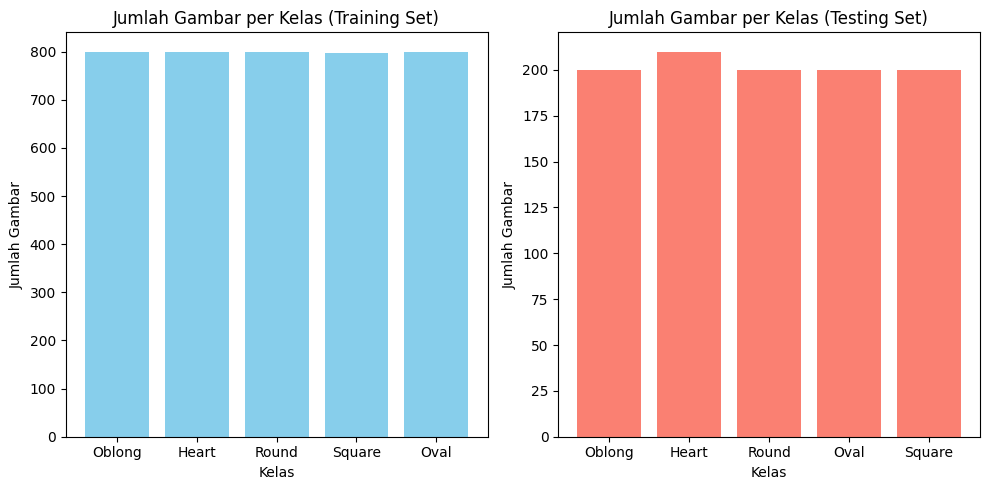

In [ ]:
def count_images_in_classes(directory):
    """
    Fungsi untuk menghitung jumlah gambar di setiap kelas dalam direktori.

    Args:
        directory (str): Jalur ke direktori dataset.

    Returns:
        dict: Kamus dengan nama kelas sebagai kunci dan jumlah gambar sebagai nilai.
    """
    class_counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):  # Pastikan hanya menghitung folder
            class_counts[class_name] = len(os.listdir(class_path))
    return class_counts

# Hitung jumlah gambar untuk masing-masing kelas
train_counts = count_images_in_classes(train_dr_new)
test_counts = count_images_in_classes(val_dr_new)

# Plot jumlah data training
plt.figure(figsize=(10, 5))

# Bar chart untuk training set
plt.subplot(1, 2, 1)
plt.bar(train_counts.keys(), train_counts.values(), color='skyblue')
plt.title('Jumlah Gambar per Kelas (Training Set)')
plt.xlabel('Kelas')
plt.ylabel('Jumlah Gambar')

# Bar chart untuk testing set
plt.subplot(1, 2, 2)
plt.bar(test_counts.keys(), test_counts.values(), color='salmon')
plt.title('Jumlah Gambar per Kelas (Testing Set)')
plt.xlabel('Kelas')
plt.ylabel('Jumlah Gambar')

# Menampilkan plot
plt.tight_layout()
plt.show()

In [ ]:
IMG_SHAPE = (224, 224, 3)

base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=IMG_SHAPE
)

tuning_layer_name = 'block_15_expand'
tuning_layer = base_model.get_layer(tuning_layer_name)
tuning_index = base_model.layers.index(tuning_layer)

# Membekukan semua layer sebelum tuning_layer
for layer in base_model.layers[:tuning_index]:
    layer.trainable = False

# Layer augmentasi
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomZoom(0.2),
    RandomContrast(0.2),
    RandomTranslation(0.1, 0.1),
], name='data_augmentation')

In [ ]:
import tensorflow_datasets as tfds

# Fungsi augmentasi
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)  # Contoh augmentasi
    return image, label

# Fungsi preprocessing
def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

# --- Train Dataset ---
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dr_new,
    labels='inferred',
    label_mode='categorical',
    image_size=(224, 224),
    interpolation='nearest',
    batch_size=32,
    shuffle=True
)

train_class_names = train_ds.class_names
train_ds = train_ds.map(augment).map(preprocess).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# --- Validation Dataset ---
validation_ds = tf.keras.utils.image_dataset_from_directory(
    val_dr_new,
    labels='inferred',
    label_mode='categorical',
    image_size=(224, 224),
    interpolation='nearest',
    batch_size=32,
    shuffle=False,
)

validation_class_names = validation_ds.class_names
validation_ds = validation_ds.map(preprocess).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

Found 3996 files belonging to 5 classes.
Found 1010 files belonging to 5 classes.


In [ ]:
def count_files_per_class(dataset, class_names): # Tambahkan parameter class_names
  """
  Menghitung jumlah file untuk setiap kelas dalam dataset.

  Args:
    dataset: Dataset TensorFlow.
    class_names: List of class names. # Parameter baru

  Returns:
    Dictionary yang berisi jumlah file untuk setiap kelas.
  """
  class_counts = {}
  for images, labels in dataset:
    for label in labels.numpy():
      class_index = np.argmax(label)
      class_name = class_names[class_index]  # Gunakan class_names yang disimpan
      class_counts[class_name] = class_counts.get(class_name, 0) + 1
  return class_counts

# --- Hitung dan tampilkan jumlah file per kelas ---
print("Training Dataset:")
train_counts = count_files_per_class(train_ds, train_class_names) # Gunakan class_names yang disimpan
for class_name, count in train_counts.items():
  print(f"  {class_name}: {count}")

print("Validation Dataset:")
validation_counts = count_files_per_class(validation_ds, validation_class_names) # Gunakan class_names yang disimpan
for class_name, count in validation_counts.items():
  print(f"  {class_name}: {count}")

Training Dataset:
  Round: 800
  Oval: 800
  Oblong: 799
  Heart: 799
  Square: 798
Validation Dataset:
  Heart: 210
  Oblong: 200
  Oval: 200
  Round: 200
  Square: 200


In [ ]:
model = Sequential([
    data_augmentation,
    base_model,
    # Conv2D(256, (3, 3), activation='relu'),
    # MaxPooling2D(pool_size=(2, 2)),
    # Dropout(0.5),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dense(len(train_counts), activation='softmax')
])

model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_11 (Flatten)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 1,206,080 (4.60 MB)

 Non-trainable params: 1,051,904 (4.01 MB)

In [ ]:
learning_rate = 0.0001

model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    metrics=['accuracy']
)

In [ ]:
EPOCH = 50
BATCH_SIZE = 32

history = model.fit(
    train_ds,
    epochs=EPOCH,
    verbose=1,
    validation_data=validation_ds,
    batch_size=BATCH_SIZE
)

Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 42s 264ms/step - accuracy: 0.2040 - loss: 2.3082 - val_accuracy: 0.2802 - val_loss: 1.6055
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 18s 83ms/step - accuracy: 0.2679 - loss: 1.5962 - val_accuracy: 0.2277 - val_loss: 1.6652
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 79ms/step - accuracy: 0.3404 - loss: 1.4788 - val_accuracy: 0.2535 - val_loss: 1.6612
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 82ms/step - accuracy: 0.3938 - loss: 1.4138 - val_accuracy: 0.2495 - val_loss: 1.8272
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 84ms/step - accuracy: 0.4286 - loss: 1.3578 - val_accuracy: 0.3188 - val_loss: 1.8228
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 79ms/step - accuracy: 0.4611 - loss: 1.2943 - val_accuracy: 0.3515 - val_loss: 1.7628
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - accuracy: 0.4960 - loss: 1.2477 - val_accuracy: 0.3792 - val_loss: 1.7178
Epoch 8/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 83ms/step - accuracy: 0.5214 - loss: 1.1900 -

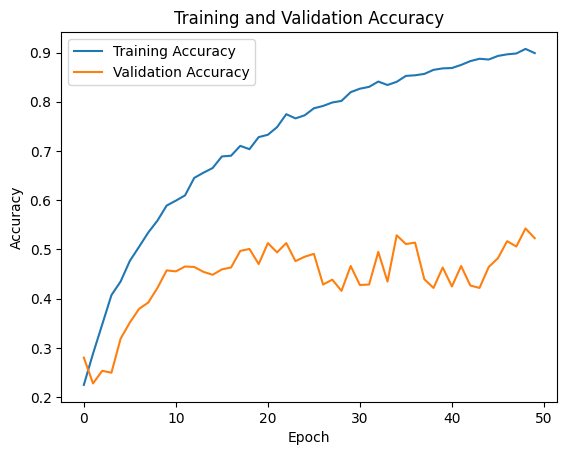

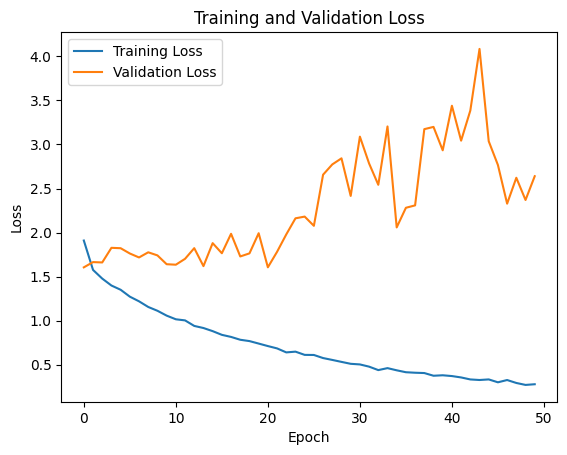

In [ ]:
# Visualisasi akurasi
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

# Visualisasi loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.show()

In [ ]:
def predict_and_compare(testing_ds, model, class_names): # Add class_names as an argument
  """
  Memprediksi bentuk wajah dari gambar di testing_ds dan membandingkannya dengan label.

  Args:
    testing_ds: Dataset testing TensorFlow.
    model: Model TensorFlow yang sudah dilatih.
    class_names: List of class names. # Document the new argument

  Returns:
    List yang berisi tuple (image_path, predicted_label, true_label, is_correct).
  """

  results = []
  for image_batch, label_batch in testing_ds.as_numpy_iterator():
    for image, label in zip(image_batch, label_batch):
      # Prediksi
      image = tf.expand_dims(image, 0)
      predictions = model.predict(image)
      predicted_class_index = np.argmax(predictions[0])
      predicted_label = class_names[predicted_class_index] # Use class_names argument

      # Label sebenarnya
      true_label = class_names[np.argmax(label)] # Use class_names argument

      # Perbandingan
      is_correct = predicted_label == true_label

      # Simpan hasil
      results.append((image, predicted_label, true_label, is_correct))

  return results

class_names_test = sorted(os.listdir(val_dr_new))

results = predict_and_compare(testing_ds, model, class_names)

# Tampilkan beberapa hasil
for image, predicted_label, true_label, is_correct in results[:10]:  # Tampilkan 10 hasil pertama
  print(f"Predicted: {predicted_label}, True: {true_label}, Correct: {is_correct}")

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import os

class_names_train = sorted(os.listdir(train_dr_new))

# Filter out any non-directory entries (like hidden files)
class_names_train = [name for name in class_names if os.path.isdir(os.path.join(train_dr_new, name))]


# Dapatkan prediksi untuk data testing
y_pred = model.predict(validation_ds)
y_pred = np.argmax(y_pred, axis=1)

# Dapatkan label sebenarnya untuk data testing
y_true = np.concatenate([y for x, y in validation_ds], axis=0)
y_true = np.argmax(y_true, axis=1)

# Hitung Presisi, Recall dan F1-score untuk setiap kelas
f1_scores = f1_score(y_true, y_pred, average=None)
precision_scores = precision_score(y_true, y_pred, average=None)
recall_scores = recall_score(y_true, y_pred, average=None)

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step


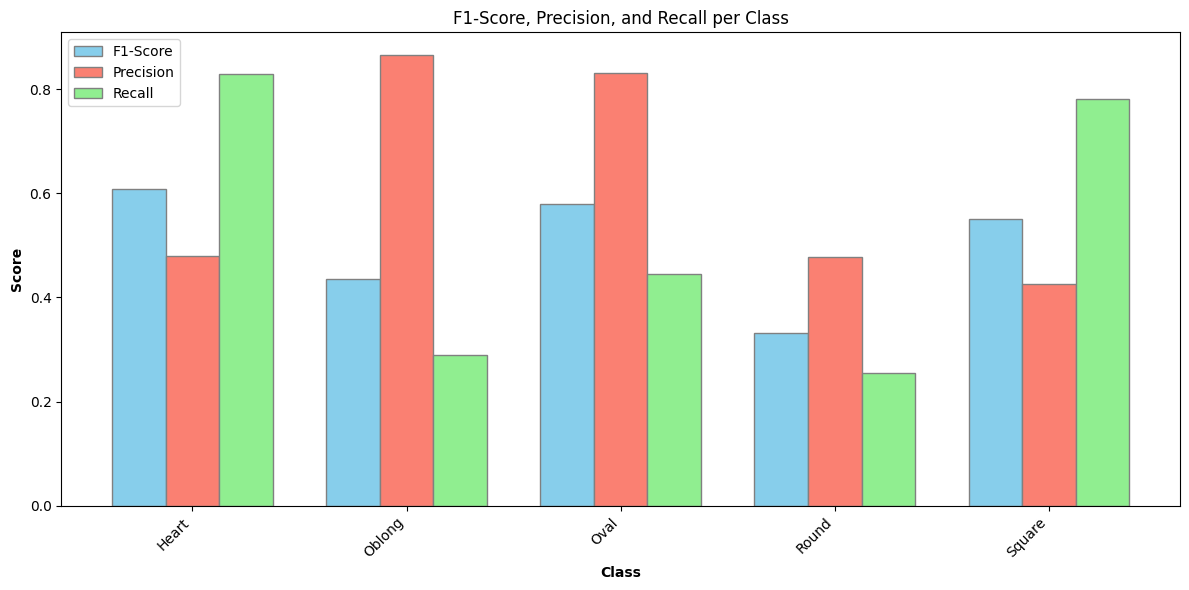

In [ ]:
   # Lebar bar
   barWidth = 0.25

   # Posisi bar
   r1 = np.arange(len(class_names))
   r2 = [x + barWidth for x in r1]
   r3 = [x + barWidth for x in r2]

   # Buat bar chart
   plt.figure(figsize=(12, 6))  # Sesuaikan ukuran jika perlu
   plt.bar(r1, f1_scores, color='skyblue', width=barWidth, edgecolor='grey', label='F1-Score')
   plt.bar(r2, precision_scores, color='salmon', width=barWidth, edgecolor='grey', label='Precision')
   plt.bar(r3, recall_scores, color='lightgreen', width=barWidth, edgecolor='grey', label='Recall')

   # Tambahkan label dan judul
   plt.title('F1-Score, Precision, and Recall per Class')
   plt.xlabel('Class', fontweight='bold')
   plt.ylabel('Score', fontweight='bold')
   plt.xticks([r + barWidth for r in range(len(class_names))], class_names, rotation=45, ha='right')
   plt.legend()
   plt.tight_layout()
   plt.show()

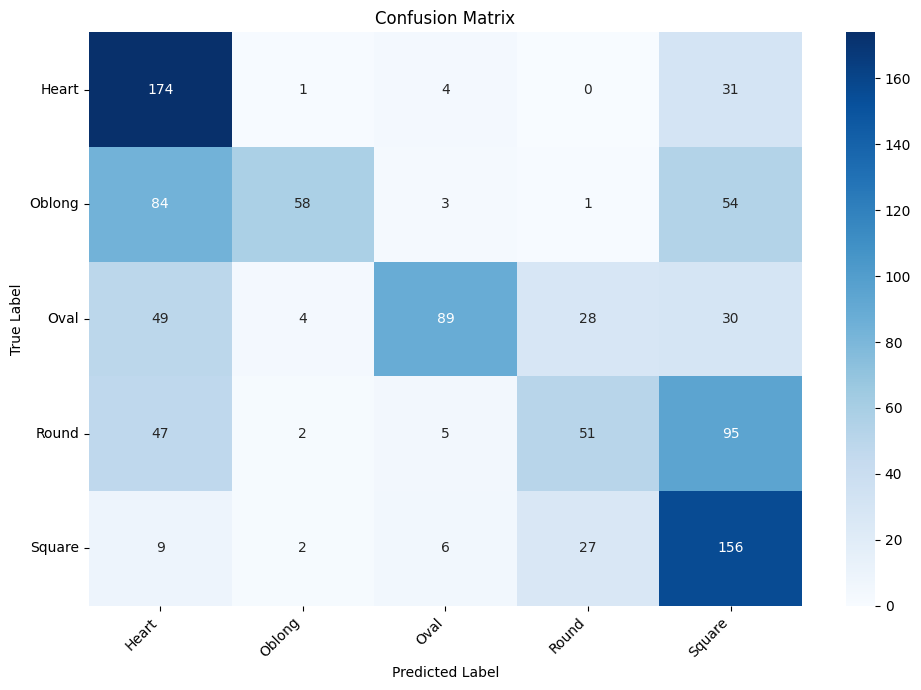

In [ ]:
# Hitung confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Visualisasikan confusion matrix menggunakan seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45, ha='right')  # Rotasi label sumbu x agar mudah dibaca
plt.yticks(rotation=0)  # Rotasi label sumbu y agar mudah dibaca (opsional)
plt.tight_layout()
plt.show()

In [ ]:
model.save('/content/drive/MyDrive/face_shape_classifier.h5')

## Convert to tfLite

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('/content/drive/MyDrive/Model_Capstone/face_shape_classifier.tflite', 'wb') as f:
    f.write(tflite_model)